In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import random
import cv2
import numpy as np
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import utils
from mrcnn import visualize
from config import BUS_DS_Config
from dataset import BUS_Dataset
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
# Display Model Configuration
config = BUS_DS_Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     32
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 32
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
# Directory to save logs and trained model
# Root directory of the project
ROOT_DIR = '/external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models'
MODEL_DIR = os.path.join(ROOT_DIR, 'trained_models')

class InferenceConfig(BUS_DS_Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

model_path = model.find_last()
# # Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Loading weights from  /external_drive/BUS_Deep_Learning/models/mask_rcnn_seg_models/trained_models/instance-seg-compact20200210T1309/mask_rcnn_instance-seg-compact_0020.h5
Re-starting from epoch 20


In [4]:
class_names = np.array(['lesion'])

In [5]:
path_to_train_set = '/external_drive/BUS_Deep_Learning/data/seg_dir_nn/train_images'
path_to_val_set = '/external_drive/BUS_Deep_Learning/data/seg_dir_nn/val_images'
# Training dataset
dataset_train = BUS_Dataset()
dataset_train.load_data(class_names, path_to_train_set)
dataset_train.prepare()
# Validation dataset
dataset_val = BUS_Dataset()
dataset_val.load_data(class_names, path_to_val_set)
dataset_val.prepare()

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (128, 128, 1)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  566.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int64
gt_bbox                  shape: (1, 4)                min:   39.00000  max:   98.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:  255.00000  uint8


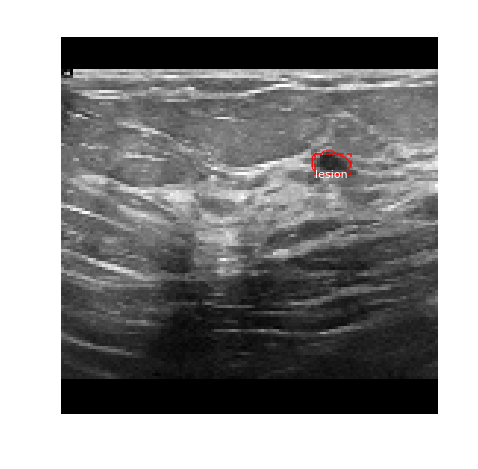

In [17]:
# Test on a random image
image_id = 6#random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image_for_disp = np.squeeze(original_image, axis=2)
image_for_disp = cv2.cvtColor(image_for_disp,cv2.COLOR_GRAY2RGB)

visualize.display_instances(image_for_disp, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 1)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 1)      min: -117.00000  max:  137.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


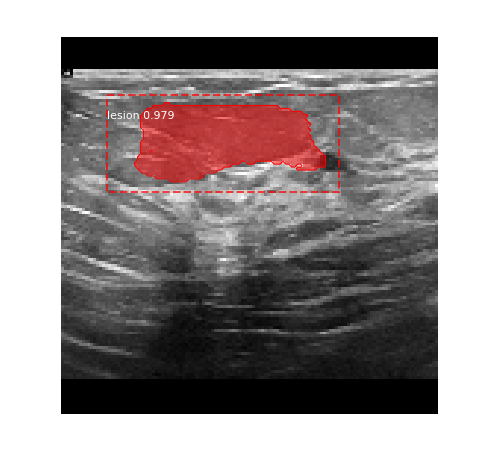

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(image_for_disp, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

In [15]:
#Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
def merge_masks(arr):
    if np.any(arr!=0):
        return 1
    else:
        return 0 

image_ids = dataset_train.image_ids
IOU = []
for image_id in image_ids:
    print('image id : ', image_id)
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    if r['masks'].shape[2]==0:
        mask = np.zeros((128,128)).astype(np.uint8)  
    else:
        mask = r['masks'][:, :, 0].astype(np.uint8)
    gt_mask = np.apply_along_axis(merge_masks, 2, gt_mask).astype(np.uint8)
# #     If no ground truth mask define mask of zeroes
#     if gt_mask.shape[2]==0:
#         gt_mask = np.zeros((128,128)).astype(np.uint8)  
#     elif gt_mask.shape[2]==1:      
#         gt_mask = np.squeeze(gt_mask).astype(np.uint8)   
#     else:
#         gt_mask = np.apply_along_axis(merge_masks, 2, gt_mask).astype(np.uint8)            
    iou = sum(cv2.bitwise_and(mask,gt_mask).flatten())/sum(cv2.bitwise_or(mask,gt_mask).flatten())
    print('iou --> ',iou)
    IOU.append(iou)
#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))

image id :  0
iou -->  0.7021276595744681
image id :  1
iou -->  0.1689497716894977
image id :  2
iou -->  0.30716723549488056
image id :  3
iou -->  0.7905759162303665
image id :  4
iou -->  0.5266846361185984
image id :  5
iou -->  0.7657430730478589
image id :  6
iou -->  0.012667660208643815
image id :  7
iou -->  0.0931961120640366
image id :  8
iou -->  0.64037558685446
image id :  9
iou -->  0.6177753544165758
image id :  10
iou -->  0.7582216808769793
image id :  11
iou -->  0.6015120781855062
image id :  12
iou -->  0.0
image id :  13
iou -->  0.5109170305676856
image id :  14
iou -->  0.0
image id :  15
iou -->  0.6410256410256411
image id :  16
iou -->  0.9
image id :  17
iou -->  0.0
image id :  18
iou -->  0.6527777777777778
image id :  19
iou -->  0.0
image id :  20
iou -->  0.0
image id :  21
iou -->  0.7875939849624061
image id :  22
iou -->  0.0
image id :  23
iou -->  0.7324099722991689
image id :  24
iou -->  0.7045977011494253
image id :  25
iou -->  0.0
image id : 

iou -->  0.1294378698224852
image id :  196
iou -->  0.2623688155922039
image id :  197
iou -->  0.5030487804878049
image id :  198
iou -->  0.12885985748218529
image id :  199
iou -->  0.0
image id :  200
iou -->  0.6159052453468697
image id :  201
iou -->  0.8273809523809523
image id :  202
iou -->  0.6672582076308784
image id :  203
iou -->  0.7556644213104715
image id :  204
iou -->  0.6359884440775898
image id :  205
iou -->  0.0365125405220952
image id :  206
iou -->  0.5640012161751292
image id :  207
iou -->  0.9111111111111111
image id :  208
iou -->  0.46691176470588236
image id :  209
iou -->  0.797190517998244
image id :  210
iou -->  0.7508871540099361
image id :  211
iou -->  0.8625994694960212
image id :  212
iou -->  0.3333333333333333
image id :  213
iou -->  0.3606068142253171
image id :  214
iou -->  0.03254437869822485
image id :  215
iou -->  0.5767104353835522
image id :  216
iou -->  0.7088305489260143
image id :  217
iou -->  0.7703435804701627
image id :  218
i

iou -->  0.7684210526315789
image id :  388
iou -->  0.8366718027734977
image id :  389
iou -->  0.6192115143929913
image id :  390
iou -->  0.0
image id :  391
iou -->  0.0
image id :  392
iou -->  0.1270408163265306
image id :  393
iou -->  0.7375565610859729
image id :  394
iou -->  0.43004653868528214
image id :  395
iou -->  0.18726114649681527
image id :  396
iou -->  0.6942179392142328
image id :  397
iou -->  0.6321138211382114
image id :  398
iou -->  0.759377211606511
image id :  399
iou -->  0.6513695338779433
image id :  400
iou -->  0.8312958435207825
image id :  401
iou -->  0.35911602209944754
image id :  402
iou -->  0.03656597774244833
image id :  403
iou -->  0.01347305389221557
image id :  404
iou -->  0.7131147540983607
image id :  405
iou -->  0.5319943951424568
image id :  406
iou -->  0.0
image id :  407
iou -->  0.6385542168674698
image id :  408
iou -->  0.5908346972176759
image id :  409
iou -->  0.480275516593613
image id :  410
iou -->  0.7349896480331263
im

In [16]:
print(np.mean(IOU))

0.5053321917905683
